In [306]:
from datetime import datetime
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, StackingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import pairwise_distances_argmin_min

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [307]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [308]:
# Загрузка данных
event_log = pd.read_csv('drive/MyDrive/event_log.csv', sep= ';')

In [309]:
event_log.head()

,case_id,event_name,event_time,employee
0,211182,Дополнение заявки > Завершено,2023-02-23 07:46:30.213,Сотрудник #11302
1,211182,Дополнение заявки > Начато,2023-02-23 08:07:27.036,Сотрудник #11302
2,211182,Дополнение заявки > Завершено,2023-02-23 08:10:34.112,Сотрудник #11302
3,211182,Дополнение заявки > Начато,2023-02-23 08:12:40.514,Сотрудник #11302
4,211182,Дополнение заявки > Завершено,2023-02-23 08:18:08.644,Сотрудник #11302


In [310]:
event_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262174 entries, 0 to 262173
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   case_id     262174 non-null  int64 
 1   event_name  262174 non-null  object
 2   event_time  262174 non-null  object
 3   employee    262174 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.0+ MB


In [311]:
event_log = event_log.sort_values(['case_id', 'event_time'])

Без сортировки некоторые значения получаются отрицательными

In [312]:
# Преобразуем строки с временем в объекты datetime
event_log["event_time"] = pd.to_datetime(event_log["event_time"])

In [313]:
%%time
# Вычисляем разницу между событиями
event_log["time_diff"] = event_log.groupby(['case_id', 'employee'])["event_time"].diff().shift(-1).dt.total_seconds()

result_df = event_log.loc[:, ["case_id", "event_name", "time_diff", "employee"]].copy()
# Убираю разницу времени между событиями, если сотрудник изменился
result_df['time_diff'] = result_df['time_diff'].where(result_df['employee'].eq(result_df['employee'].shift(-1)), other=0)
event_log.drop(columns = 'time_diff', inplace = True)

# Добавлю обьединенную строчку для наглядности
result_df["event_name"] = result_df["event_name"] + " - " + result_df["event_name"].shift(-1)

result_df = result_df[~result_df["time_diff"].isna()]

# Объединяю result_df с исходным event_log для добавления event_time
result_df = result_df.merge(event_log[['case_id', 'event_time']], left_index=True, right_index=True)

result_df["next_event_time"] = result_df['event_time'].shift(-1)

# Удалю ненужные столбцы case_id после merge
result_df = result_df.drop(columns = 'case_id_y').rename(columns = {'case_id_x':'case_id'})

# Удалю нулевые значения так как при смене сотрудника мы ставили нули, так же некоторые события произошли одновременно, что тоже ставит нули.
result_df = result_df.loc[(result_df.time_diff != 0)]

CPU times: user 456 ms, sys: 78.5 ms, total: 534 ms
Wall time: 531 ms


Я решил вычислять разницу между событиями только в пределах одного сотрудника т.е. при смене сотрудника в одном кейсе не будет учитываться время между событиями так как некоторые кейсы спустя большое время(день, неделя, месяц) может обрабатывать другой сотрудник и таких событий достаточно много чтобы выбросы стали значимыми.

In [314]:
result_df.head()

,case_id,event_name,time_diff,employee,event_time,next_event_time
191915,173691,Заявка отправлена - Заявка подана частично,3.939,Сотрудник #00112,2022-10-01 03:08:58.256,2022-10-01 03:09:02.195
191916,173691,Заявка подана частично - Заявка предварительно...,54.453,Сотрудник #00112,2022-10-01 03:09:02.195,2022-10-01 03:09:56.648
191917,173691,Заявка предварительно принята - Дополнение зая...,2.930,Сотрудник #00112,2022-10-01 03:09:56.648,2022-10-01 03:09:59.578
2174,173691,Дополнение заявки > Начато - Дополнение заявки...,340.785,Сотрудник #00000,2022-10-01 06:37:32.393,2022-10-01 06:43:13.178
2175,173691,Дополнение заявки > Завершено - Дополнение зая...,9884.597,Сотрудник #00000,2022-10-01 06:43:13.178,2022-10-01 09:27:57.775


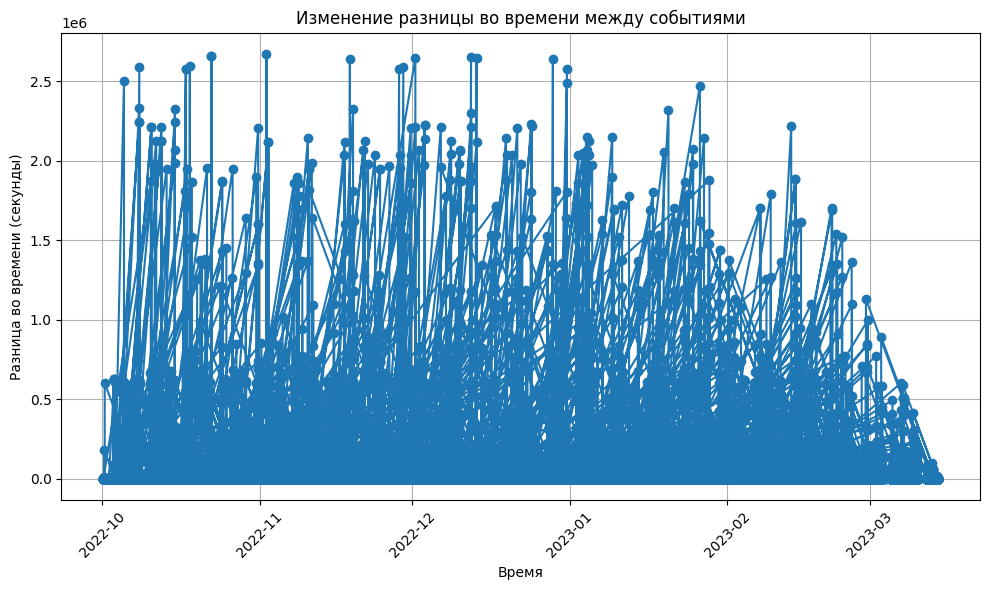

In [315]:
plt.figure(figsize=(10, 6))
plt.plot(result_df['event_time'], result_df['time_diff'], marker='o', linestyle='-')
plt.title('Изменение разницы во времени между событиями')
plt.xlabel('Время')
plt.ylabel('Разница во времени (секунды)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Из графика мы можем подчеркнуть что у нас присутствует много выбросов


In [316]:
le_emp = LabelEncoder()
result_df.employee = le_emp.fit_transform(result_df.employee)
le_en = LabelEncoder()
result_df.event_name =le_en.fit_transform(result_df.event_name)

In [317]:
from sklearn.ensemble import IsolationForest

def remove_anomalies(data, contamination=0.1):
  model = IsolationForest(contamination=contamination)
  model.fit(data.drop(columns = ['event_time', 'next_event_time']))
  # Предсказание аномалий (1 - нормальные наблюдения, -1 - аномалии)
  anomalies = model.predict(data.drop(columns = ['event_time', 'next_event_time']))
  # Удаление аномалий из набора данных
  cleaned_data = data[anomalies == 1]
  return cleaned_data

cleaned_data = remove_anomalies(result_df)

print("Размер исходных данных:", result_df.shape)
print("Размер очищенных данных:", cleaned_data.shape)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Размер исходных данных: (175279, 6)
Размер очищенных данных: (157751, 6)


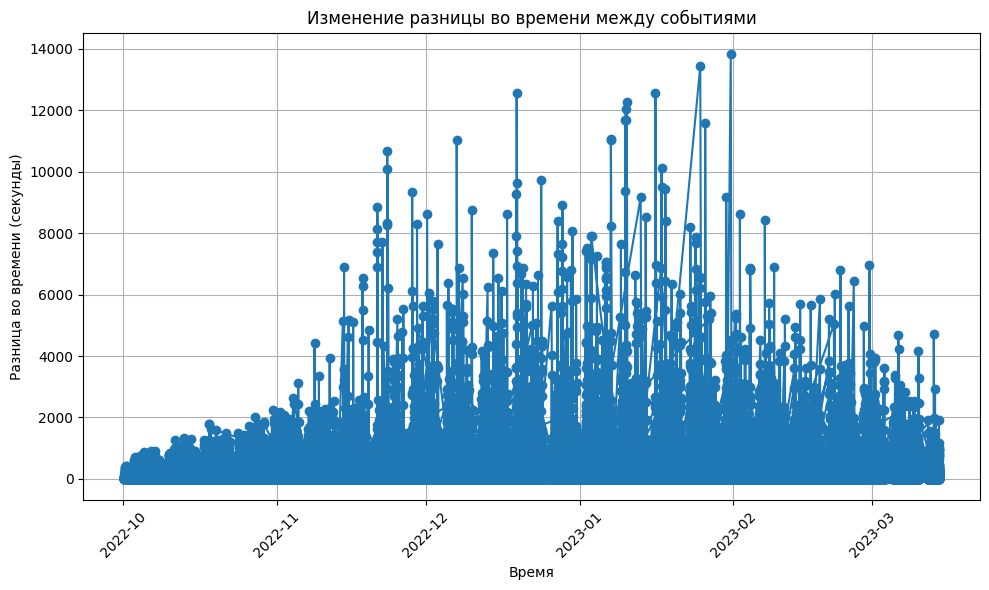

In [318]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data['event_time'], cleaned_data['time_diff'], marker='o', linestyle='-')
plt.title('Изменение разницы во времени между событиями')
plt.xlabel('Время')
plt.ylabel('Разница во времени (секунды)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Тут мы постарались отделить выбросы и использовали IsolationForest

In [319]:
Y = cleaned_data.time_diff
X = cleaned_data.drop(columns=['time_diff', 'next_event_time', 'event_time'])
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

#result
print(results.summary())
results.predict(X)

                            OLS Regression Results                            
Dep. Variable:              time_diff   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2256.
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        01:07:02   Log-Likelihood:            -1.1714e+06
No. Observations:              157751   AIC:                         2.343e+06
Df Residuals:                  157747   BIC:                         2.343e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        193.5148     17.789     10.878      0.0

191915     87.393987
191916     83.274749
191917     77.095893
54640      94.694590
2177       52.888805
             ...    
148498    126.150073
237595    102.698110
237596     96.519254
166790    109.700520
166791    192.085270
Length: 157751, dtype: float64

Значение коэффициента детерминации равно 0.05, что означает, что только около 5% изменчивости зависимой переменной объясняется моделью. Значит нам следует использовать более сложные модели или попробовать использовать кластеризацию.

 F-статистика используется для проверки значимости регрессии в целом. Значение F-статистики равно 2746.0, а вероятность близка к нулю, что указывает на то, что модель в целом является значимой.

<Axes: >

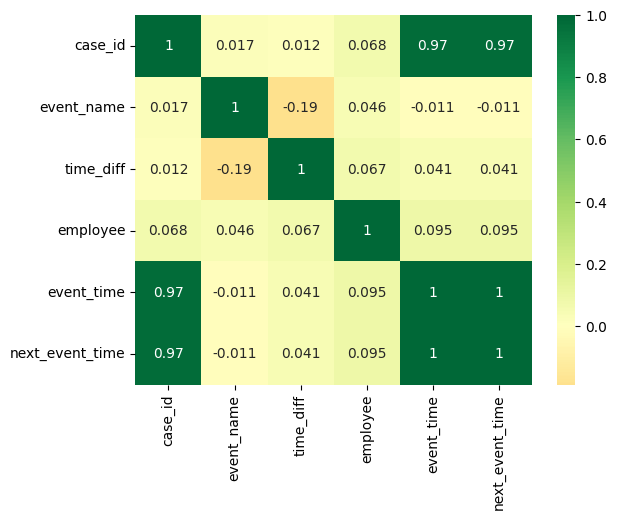

In [320]:
sns.heatmap(cleaned_data.corr(), xticklabels=cleaned_data.corr().columns, yticklabels=cleaned_data.corr().columns, cmap='RdYlGn', center=0, annot=True)

Высокая корреляция наблюдается только у переменных даты, которые не будут учавствовать в модели регресси, так что все хорошо.

Я решил попробовать реализовать оба подхода к которым я пришел (кластеризация и регрессия).

# **Регрессия**

In [371]:
X = cleaned_data[['case_id', 'event_name', 'employee']]
y = cleaned_data['time_diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [372]:
sk = StandardScaler()
X_train = sk.fit_transform(X_train)
X_test = sk.transform(X_test)

In [373]:
model =  BaggingRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))
mae_model = mean_absolute_error(y_test, y_pred)

print(f"Model: {model}, RMSE: {rmse_model}, MAE: {mae_model}")

Model: BaggingRegressor(), RMSE: 398.43174781142983, MAE: 129.78280035721633


In [374]:
model = GradientBoostingRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))
mae_model = mean_absolute_error(y_test, y_pred)

print(f"Model: {model}, RMSE: {rmse_model}, MAE: {mae_model}")

Model: GradientBoostingRegressor(), RMSE: 364.2495571278423, MAE: 131.0095924796059


In [389]:
%%time
param_rf = {'n_estimators': [41],
        'max_depth': [11]}

grid_search_cv_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_rf, cv = 5, n_jobs=-1)
grid_search_cv_rf.fit(X_train, y_train)
grid_rf = grid_search_cv_rf.best_estimator_
y_pred = grid_rf.predict(X_test)

rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))
mae_model = mean_absolute_error(y_test, y_pred)

print(f"Model: {model}, RMSE: {rmse_model}, MAE: {mae_model}")

Model: GradientBoostingRegressor(), RMSE: 353.17644762351233, MAE: 117.82486976455897
CPU times: user 6.7 s, sys: 82.7 ms, total: 6.78 s
Wall time: 35.8 s


In [390]:
grid_search_cv_rf.best_params_

{'max_depth': 11, 'n_estimators': 41}

In [380]:
%%time
param = {'learning_rate': [0.1],
      'n_estimators': [40],
      'max_depth': [10],
      'min_child_weight': [15]
}

grid_search_cv_xgb = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = param, cv = 5, n_jobs=-1)
grid_search_cv_xgb.fit(X_train, y_train)
grid_xgb = grid_search_cv_xgb.best_estimator_
y_pred = grid_xgb.predict(X_test)

rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))
mae_model = mean_absolute_error(y_test, y_pred)

print(f"Model: {model}, RMSE: {rmse_model}, MAE: {mae_model}")

Model: GradientBoostingRegressor(), RMSE: 351.17808121292967, MAE: 117.81295704588288
CPU times: user 3.02 s, sys: 20 ms, total: 3.04 s
Wall time: 5.48 s


In [379]:
grid_search_cv_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 15,
 'n_estimators': 40}

В результате небольшого перебора гиперпараметров и моделей(модели были протестированны без подбора гиперпараметров и лучшие из них с подбором) можно сделать вывод, что случайный лес и xgbr показали себя примерно одинакого, но при этом xgbr работает намного быстрее.

В данном случае мы можем предсказывать разницу между событиями, тем самым видеть насколько мы ускорились или замедлились с точностью самой модели, а точность вышла неплохая.


# **Кластеризация**

In [364]:
result_df.head(30)

,case_id,event_name,time_diff,employee,event_time,next_event_time
191915,173691,84,3.939,1,2022-10-01 03:08:58.256,2022-10-01 03:09:02.195
191916,173691,86,54.453,1,2022-10-01 03:09:02.195,2022-10-01 03:09:56.648
191917,173691,89,2.930,1,2022-10-01 03:09:56.648,2022-10-01 03:09:59.578
2174,173691,34,340.785,0,2022-10-01 06:37:32.393,2022-10-01 06:43:13.178
2175,173691,26,9884.597,0,2022-10-01 06:43:13.178,2022-10-01 09:27:57.775
54640,173691,91,111.402,15,2022-10-01 09:33:54.614,2022-10-01 09:35:46.016
54642,173691,136,1.472,15,2022-10-01 09:35:46.016,2022-10-01 09:35:47.488
54643,173691,154,0.095,15,2022-10-01 09:35:47.488,2022-10-01 09:35:47.583
2177,173691,100,1.109,0,2022-10-01 09:35:47.682,2022-10-01 09:35:48.791
2178,173691,28,24.652,0,2022-10-01 09:35:48.791,2022-10-01 09:36:13.443


In [365]:
X_test = result_df.loc[result_df.case_id ==173694]
X_train = cleaned_data.loc[cleaned_data.case_id != 173694]

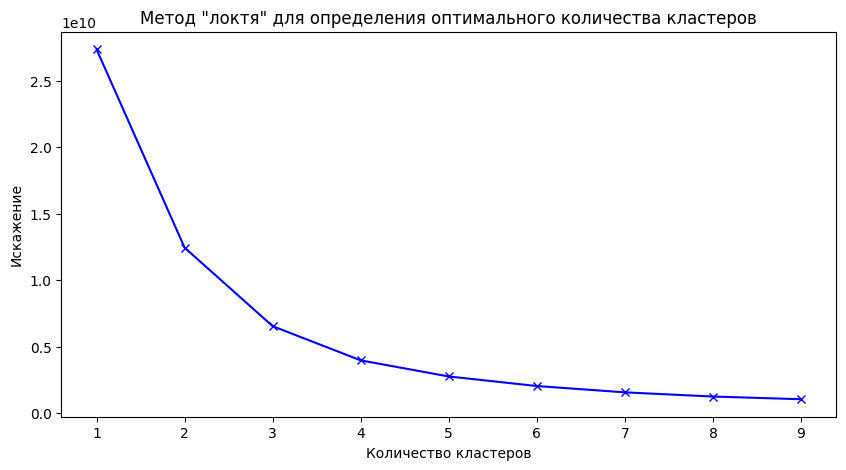

In [366]:
X = X_train[['event_name', 'time_diff']]

distortions = []
K = range(1, 10)
for k in K:
  kmeans = KMeans(n_clusters=k, n_init = 'auto')
  kmeans.fit(X)
  distortions.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Количество кластеров')
plt.ylabel('Искажение')
plt.title('Метод "локтя" для определения оптимального количества кластеров')
plt.show()

In [367]:
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, n_init = 'auto')
labels = kmeans.fit_predict(X)

X_train.loc[:, 'labels'] = labels

# Вывод результатов
for cluster_num in range(optimal_k):
  cluster_data = X_train[X_train['labels'] == cluster_num]
  print(f"Кластер {cluster_num}:")
  print(cluster_data['time_diff'].mean())
  print()

Кластер 0:
544.2523668918195

Кластер 1:
20.217357937732906

Кластер 2:
3305.471887351779

Кластер 3:
211.1201194931312

Кластер 4:
9681.696333333333

Кластер 5:
1871.7021852808264

Кластер 6:
1070.1258655486072

Кластер 7:
5786.74761081081



<ipython-input-367-85c7cdc44686>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, 'labels'] = labels


Тут мы видим, что некоторые заявки могут обрабатываться дольше, а некоторые быстрее.

In [368]:
# Применение модели кластеризации к тестовым данным
X_test.loc[:, 'labels'] = kmeans.predict(X_test[['event_name', 'time_diff']])

# Сравнение кластерного распределения в тестовых данных с обучающими данными
train_cluster_distribution = X_train['labels'].value_counts(normalize=True).sort_index()
test_cluster_distribution = pd.Series(X_test['labels']).value_counts(normalize=True).sort_index()

# Вывод результатов
print("Кластерное распределение в обучающих данных:")
print(train_cluster_distribution)
print("\nКластерное распределение в тестовых данных:")
print(test_cluster_distribution)

Кластерное распределение в обучающих данных:
labels
0    0.059132
1    0.743475
2    0.003208
3    0.160603
4    0.000285
5    0.009821
6    0.022304
7    0.001173
Name: proportion, dtype: float64

Кластерное распределение в тестовых данных:
labels
0    0.052632
1    0.684211
3    0.236842
5    0.026316
Name: proportion, dtype: float64


<ipython-input-368-7f69a702eacf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, 'labels'] = kmeans.predict(X_test[['event_name', 'time_diff']])


In [370]:
# Вычисление средних расстояний в классе для каждого кластера на обучающих данных
mean_time_per_cluster = []
for cluster_num in range(optimal_k):
  cluster_data = X_train[X_train['labels'] == cluster_num]
  mean_time_per_cluster.append(cluster_data['time_diff'].mean())

threshold = 2  # Порог для определения изменения скорости

any_outside_threshold = False

for i, cluster_label in enumerate(X_test['labels']):
  time_diff = X_test.iloc[i]['time_diff']
  obs = X_test.iloc[i].copy()
  obs.employee = le_emp.inverse_transform([X_test.iloc[i].employee])[0]
  obs.event_name = le_en.inverse_transform([X_test.iloc[i].event_name])[0]
  mean_time_diff_in_cluster = mean_time_per_cluster[cluster_label]
  speed_difference = time_diff - mean_time_diff_in_cluster

  if abs(speed_difference) / mean_time_diff_in_cluster > threshold:
    print(obs)
    any_outside_threshold = True
    if speed_difference < 0:
        print(f"Наблюдение {obs.case_id} ускорилось на {speed_difference:.2f} по сравнению со средней разницой времени в кластере {cluster_label}")
    else:
        print(f"Наблюдение {obs.case_id} замедлилось на {abs(speed_difference):.2f} по сравнению со средней разницой времени в кластере {cluster_label}")
    print()

if not any_outside_threshold:
  print("Все наблюдения находятся в пределах порога.")


case_id                                                 173694
event_name         Дополнение заявки > Начато - Заявка принята
time_diff                                               92.603
employee                                      Сотрудник #11201
event_time                          2022-10-03 08:32:52.818000
next_event_time                     2022-10-03 08:34:25.421000
labels                                                       1
Name: 239086, dtype: object
Наблюдение 173694 замедлилось на 72.39 по сравнению со средней разницой времени в кластере 1

case_id                                                       173694
event_name         Звонок после предложения > Начато - Звонок пос...
time_diff                                                     84.868
employee                                            Сотрудник #11203
event_time                                2022-10-26 13:48:57.136000
next_event_time                           2022-10-26 13:50:22.004000
labels                 

Здесь мы взяли данные с выбросами или задержками которые у нас отсек IsolationForest и видим данные по каждой записи